# DenseNet121 — Frozen Backbone Transfer Learning  
**Objective:** Train a chest X-ray multi-label classifier using a **pretrained DenseNet121** where the convolutional backbone remains **frozen** and only a new classifier head is trained.

---

## 🎯 Goal of This Notebook  
Use a pretrained DenseNet121 as a **fixed feature extractor** and train only the final classifier layer(s) on the NIH ChestX-ray14 dataset.

This approach tests how far we can get **without updating backbone weights**, serving as a strong baseline.

---

## 🧠 Concept: Frozen Backbone  
A **frozen backbone** means:

- All convolutional layers from the pretrained DenseNet121 are **not updated**
- Their weights remain exactly as learned on ImageNet
- Only the newly added classification head is trained

In practice, the model extracts features using DenseNet, and we only learn how to map those features to **14 disease labels**.

---

## ❓ Why Frozen Backbone?  
This strategy is useful when:

- We want fast training
- We have limited compute (e.g., Colab GPU)
- The dataset labels are expensive and we want to avoid overfitting early
- We want a **baseline** before exploring more complex training setups

Benefits:

- **Much faster training**
- **Fewer parameters trained** → lower memory usage
- **Reduced risk of overfitting**

---

## 🩺 Task Overview  
Dataset: **NIH ChestX-ray14**  
Task: **Multi-label disease classification (14 thoracic diseases)**  
Inputs: Images preprocessed to **RGB 224×224** (already done)

The model will output **14 sigmoid logits** (one per disease).

---

## 📦 What This Notebook Will Do  
1. Load pretrained DenseNet121  
2. Freeze all backbone parameters  
3. Replace classifier with a new multi-label classification head  
4. Train only the head  
5. Evaluate performance using:
   - AUROC (per class & macro)
   - F1-score
   - Loss curves

Output:

- Trained baseline DenseNet model (frozen backbone)
- Saved metrics & model checkpoint

---

## ✅ Expected Outcome  
A reproducible, well-documented baseline model using DenseNet121 as a **fixed feature extractor**, ready to compare with future experiments.

---


## 🧠 What is a Convolutional Neural Network (CNN)?

A **Convolutional Neural Network (CNN)** is a type of deep learning model designed specifically for **image data**.  
Instead of treating an image as a flat vector of pixels, CNNs understand **spatial structure** — how nearby pixels relate to each other — which makes them extremely effective for tasks like medical imaging, object detection, and image classification.

---

### 🔍 Key Idea

CNNs learn visual patterns in a hierarchy:

| Layer Stage | Learns | Example Features |
|------------|--------|------------------|
| Early Layers | Low-level patterns | edges, lines, corners |
| Middle Layers | Mid-level patterns | textures, shapes, organs |
| Deep Layers | High-level semantic concepts | disease-specific patterns, anatomical structures |

The network gradually builds **abstract representations from raw pixels**, making it capable of recognizing complex medical patterns in chest X-rays.

---

### 🧱 Core Components

#### 1️⃣ **Convolution Layers**
- Slide small filters (kernels) across the image
- Detect local patterns (lung textures, edges of ribs, opacities)

#### 2️⃣ **Non-linear Activation**
- Usually ReLU (Rectified Linear Unit)
- Introduces non-linearity → allows learning complex relationships

#### 3️⃣ **Pooling Layers**
- Reduce spatial size (downsampling)
- Keep most important information
- Helps with computation efficiency and reduces overfitting

#### 4️⃣ **Fully Connected / Classification Head**
- Final layers that map features → class scores

---

### 🎯 Why CNNs Matter in Medical Imaging

- X-rays contain **local structures** (lungs, ribs, heart)
- Diseases appear as **patterns and shapes** (opacities, nodules, infiltrations)
- CNNs can learn these visual signals directly from labeled images

Traditional ML required manual feature extraction — CNNs automate that by learning features directly from data.

---

### 🧬 Relation to Our Model

In this notebook, we use a **DenseNet121 CNN** pretrained on ImageNet.  
We will **freeze its convolutional layers**, keeping their learned visual features intact, and only train the classification head for chest diseases.

The CNN backbone already knows how to extract patterns like:

- edges
- textures
- shapes
- gradients and structures that generalize well to X-rays

We simply adapt the final mapping to predict **14 thoracic disease labels**.

---



## 🧠 What is DenseNet?

**DenseNet (Dense Convolutional Network)** is a CNN architecture where
**each layer receives inputs from all previous layers**.\
This is called **dense connectivity**.

Instead of layers passing information only to the next layer, DenseNet
organizes layers like:

    Layer 0 → Layer 1 → Layer 2 → Layer 3 ...
            ↘ Layer 2
                ↘ Layer 3
                    ↘ ...

So **every layer has direct access to all earlier feature maps**.

------------------------------------------------------------------------

### 🎛 Why Dense Connections Matter

DenseNet introduces *dense connectivity*, meaning each layer receives
input from all previous layers.\
This leads to several advantages:

| Benefit | Explanation |
| --- | --- |
| ✅ Better gradient flow | Direct paths reduce vanishing-gradient issues |
| ✅ Feature reuse | Later layers reuse features learned earlier |
| ✅ Efficient | Fewer parameters vs networks of similar depth |
| ✅ Strong representation learning | Useful patterns preserved; improves generalization |


DenseNet avoids the **vanishing gradient problem** by giving gradients
**short paths** back to early layers - similar idea to ResNet but even
more connected.

------------------------------------------------------------------------

### 🩺 Why DenseNet Works Well for X-rays

Medical imaging often needs:

-   fine-grained texture understanding (e.g., lung opacities)
-   ability to handle subtle patterns
-   efficient parameter usage (avoid overfitting on medical data)
-   strong gradient propagation for deep feature learning

DenseNet excels in **texture-heavy, subtle-detail datasets** --- exactly
like chest X-rays.

------------------------------------------------------------------------

### ❓ Does vanishing gradient matter if we're freezing the backbone?

Good question!

- In this notebook, **we are freezing the DenseNet backbone**
- That means **we are not backpropagating into DenseNet layers**
- So DenseNet's gradient-handling features **do not affect training here**

However — they *still matter* because DenseNet already learned strong features thanks to its architecture.

---

### 🧠 Why DenseNet's design still benefits us (even frozen)

**DenseNet learned strong deep features**
- Pretrained on millions of images → strong visual representations
- These features transfer well to medical images  

**Dense connectivity enabled better feature abstraction**
- Feature reuse across layers → richer learned representations
- Those features remain inside our frozen model

**Stable gradient flow enabled deep training on ImageNet**
- Dense links prevented signal decay during its original training
- We inherit a deeply-trained feature extractor

---

### ✅ In short

> We don't benefit from DenseNet's gradient flow **during our training**  
> but we *do* benefit from the **representations it learned because of it**

------------------------------------------------------------------------

### 🧩 How DenseNet fits into our frozen-backbone setup

What we use DenseNet for in this notebook:

-   As a **fixed feature extractor**
-   Providing high-quality medical-relevant features (textures, edges,
    tissue patterns)
-   Saving compute by **not retraining** deep layers
-   Only training a new **classification head** on top

This creates a **strong baseline** before we try fine-tuning later.

------------------------------------------------------------------------

### TL;DR

DenseNet helps because:

-   It learned powerful representations thanks to dense connectivity
-   It handles subtle medical textures well
-   Freezing allows fast training + avoids overfitting
-   We reuse its pre-learned features instead of training from scratch

Even though gradient benefits aren't used here (since frozen),\
**the resulting pretrained features are still valuable for our task.**


# Step 1 — Environment & Dataset setup (mount Drive, copy & unzip)

**Goal of this cell**

1. Mount Google Drive (Colab) so we can access your uploaded zip file.  
2. Copy the processed dataset zip from Drive into the Colab VM (faster I/O).  
3. Unzip into a local folder (e.g. `/content/processed_dataset/`) to be used by DataLoaders.  
4. Create standard output directories for checkpoints and metrics.  
5. Set reproducibility seeds and check device (GPU).

**Notes / conventions**
- Set `DRIVE_ZIP_PATH` to the path of your zip on Google Drive (e.g. `/content/drive/MyDrive/your/path/processed_dataset.zip`).
- We'll extract to `/content/processed_dataset/`. Adjust if you prefer another path.
- Checkpoint policy:
  - **Save the model with best validation metric** (e.g., best *val macro AUROC*). This is the primary checkpoint to keep.
  - Optionally save periodic checkpoints (`epoch_{n}.pth`) for debugging / resume — useful but not required.
  - Always save a `last.pth` at the end of training.
- We'll also create an `outputs/` folder to store:
  - `checkpoints/` (model `.pth` files)
  - `metrics/` (per-epoch JSON/CSV of scores)
  - `plots/` (loss & ROC images)



In [3]:
# Step 1 code: mount drive, copy zip, unzip, create dirs, set seed, check device

import os
import zipfile
import shutil
import random
import numpy as np
import torch

# =========== USER CONFIG - set this to your zip on Drive ===========
DRIVE_ZIP_PATH = "/content/drive/MyDrive/FML_Project/processed_dataset.zip"  # <-- EDIT THIS
EXTRACT_TO = "/content/processed_dataset"
COPY_TO_VM = "/content/processed_dataset.zip"
# ===================================================================

# mount drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    print("Not running in Colab or 'google.colab' not available. Ensure DRIVE_ZIP_PATH is reachable.")

# copy zip from drive to VM (if it exists)
if os.path.exists(DRIVE_ZIP_PATH):
    print("Copying zip from Drive to VM...")
    shutil.copy2(DRIVE_ZIP_PATH, COPY_TO_VM)
else:
    print(f"WARNING: Could not find zip at {DRIVE_ZIP_PATH}. Please update DRIVE_ZIP_PATH and re-run.")
    # still proceed if user pre-uploaded directly to VM

# unzip
if os.path.exists(COPY_TO_VM):
    print(f"Extracting {COPY_TO_VM} -> {EXTRACT_TO} ...")
    os.makedirs(EXTRACT_TO, exist_ok=True)
    with zipfile.ZipFile(COPY_TO_VM, 'r') as zf:
        zf.extractall(EXTRACT_TO)
    print("Extraction complete.")
else:
    if os.path.exists(EXTRACT_TO):
        print(f"{COPY_TO_VM} not found, but {EXTRACT_TO} already exists — skipping extraction.")
    else:
        print("No zip copied and extraction dir not present. Make sure dataset is available.")

# create outputs folders
OUT_DIR = "/content/outputs"
CHECKPOINT_DIR = os.path.join(OUT_DIR, "checkpoints")
METRICS_DIR = os.path.join(OUT_DIR, "metrics")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Created output directories:")
print(" ", CHECKPOINT_DIR)
print(" ", METRICS_DIR)
print(" ", PLOTS_DIR)

# reproducibility seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA device count:", torch.cuda.device_count(), "-", torch.cuda.get_device_name(0))

# summary of dataset folders (if extracted)
for split in ("train", "val", "test"):
    p = os.path.join(EXTRACT_TO, split)
    if os.path.exists(p):
        n = sum(len(files) for _, _, files in os.walk(p))
        print(f"{split}: found {n} files in {p}")
    else:
        print(f"{split}: directory not found at {p}")

Mounted at /content/drive
Copying zip from Drive to VM...
Extracting /content/processed_dataset.zip -> /content/processed_dataset ...
Extraction complete.
Created output directories:
  /content/outputs/checkpoints
  /content/outputs/metrics
  /content/outputs/plots
Device: cuda
CUDA device count: 1 - Tesla T4
train: found 69220 files in /content/processed_dataset/train
val: found 17304 files in /content/processed_dataset/val
test: found 25596 files in /content/processed_dataset/test


## Step 2 — Dataset, Transforms & DataLoader

In this step, we will:

1. Load NIH metadata (`Data_Entry_2017.csv`)
2. Create a mapping for all **14 disease labels**
3. Implement a custom PyTorch `Dataset` that:
   - Reads image file names per split (`train / val / test`)
   - Matches them with labels from metadata
   - Converts labels into **multi-hot tensors** (multi-label problem)
   - Applies augmentations (only for training)
4. Build efficient `DataLoader`s for training, validation & testing

### 🧠 Key Notes

- **Multi-label classification**  
  Each chest X-ray may contain **0, 1, or multiple diseases**  
  Example: `"Cardiomegaly|Effusion"`

- **`No Finding` → all-zero label vector**

- **Transforms**
  - ✅ Train: mild medical-safe augmentation  
    (random crop, horizontal flip, small rotation)
  - ✅ Val/Test: only resize + normalization

- **Normalization**  
  Using **ImageNet mean & std** because DenseNet is pretrained on ImageNet.


In [16]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

CSV_PATH = os.path.join(EXTRACT_TO, "Data_Entry_2017.csv")
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"

DISEASES = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
    "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema",
    "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
]

disease_to_idx = {d: i for i, d in enumerate(DISEASES)}

meta_df = pd.read_csv(CSV_PATH)
meta_df["Labels"] = meta_df["Finding Labels"].str.split("|")

def labels_to_tensor(labels):
    vec = torch.zeros(len(DISEASES))
    for label in labels:
        if label in disease_to_idx:
            vec[disease_to_idx[label]] = 1
    return vec

class NIH_Dataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.root = os.path.join(root, split)
        self.transform = transform

        self.files = [f for f in os.listdir(self.root) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.df = meta_df[meta_df["Image Index"].isin(self.files)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row["Image Index"])
        img = Image.open(img_path).convert("RGB")
        label = labels_to_tensor(row["Labels"])

        if self.transform:
            img = self.transform(img)

        return img, label

# transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# datasets
train_ds = NIH_Dataset(EXTRACT_TO, "train", train_transform)
val_ds   = NIH_Dataset(EXTRACT_TO, "val",   eval_transform)
test_ds  = NIH_Dataset(EXTRACT_TO, "test",  eval_transform)

# dataloaders
BATCH_SIZE = 256
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(69220, 17304, 25596)

## Step 3 — Build Frozen DenseNet-121 Backbone

We now load a **DenseNet-121 pretrained on ImageNet** and freeze its convolutional layers.

### Why freeze?
- We want to first evaluate DenseNet as a **fixed feature extractor**
- Only the **new classification head** will learn

### Architecture notes
- DenseNet uses **dense connectivity** → strong feature reuse
- Even though gradients won't flow into the frozen backbone, we still get
  the **benefits of its pretrained medical-relevant feature representations**

### Steps
1. Load `densenet121(pretrained=True)`
2. Freeze all feature extractor parameters
3. Replace the classifier with a new head for **14 diseases**
4. Move model to GPU


In [17]:
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 14

# Load DenseNet121 pre-trained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

# Count trainable params
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

trainable_params, total_params

(14350, 6968206)

## Step 4 — Loss Function & Optimizer

Since this is a **multi-label classification** problem, each image can have
0, 1, or multiple diseases. Therefore:

### 🎯 Loss Function
We use **Binary Cross-Entropy with Logits (BCEWithLogitsLoss)**:

- Applies Sigmoid + BCE in one step
- Stable for multi-label problems
- Each class is treated independently

### ⚙️ Optimizer
For the frozen-backbone setup:

- Only the classifier layers train
- We use **Adam** with a small learning rate (1e-3)
- Weight decay helps regularization



In [18]:
import torch.optim as optim

# Loss for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer only for trainable params (classifier)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-5
)

criterion, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 1e-05
 ))

## Step 4 — Training Loop + CSV Logging + Best Checkpoint Saving

In this step, we train our frozen DenseNet model and log performance metrics:

### ✅ What we do
- Train using **BCEWithLogitsLoss** (multi-label classification)
- Track:
  - `train_loss`
  - `val_loss`
  - `val_accuracy`
- Append results each epoch to a CSV file (`training_log_frozen.csv`)
- **Save the model checkpoint** only when validation loss improves

### 🛠 Key Points
- **Sigmoid is applied only during evaluation**, not inside the model
- Prediction threshold = `0.5` → disease present
- Frozen backbone → only classification layer is trained
- Checkpoint saved to:  
  `outputs/checkpoints/densenet_frozen_best.pt`

This ensures:
- We don't lose the best weights
- We can resume


In [19]:
import torch.nn.functional as F
from tqdm import tqdm
import csv

EPOCHS = 20
csv_file = f"{METRICS_DIR}/training_log.csv"
checkpoint_path = f"{CHECKPOINT_DIR}/densenet_frozen_best.pt"

best_val_loss = float("inf")  # track best model

# create CSV header if file does not exist
if not os.path.exists(csv_file):
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_accuracy"])

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ----- Validation -----
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(logits) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.numel()

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    # print metrics
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # log to CSV
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, val_loss, val_accuracy])

    # ----- Save best model -----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Saved best model at epoch {epoch} (val_loss={val_loss:.4f})")

Validating: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Epoch 1 | Train Loss: 0.1667 | Val Loss: 0.1595 | Val Acc: 0.9548
✅ Saved best model at epoch 1 (val_loss=0.1595)


Validating: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]


Epoch 2 | Train Loss: 0.1535 | Val Loss: 0.1559 | Val Acc: 0.9548
✅ Saved best model at epoch 2 (val_loss=0.1559)


Validating: 100%|██████████| 68/68 [01:00<00:00,  1.13it/s]


Epoch 3 | Train Loss: 0.1515 | Val Loss: 0.1555 | Val Acc: 0.9547
✅ Saved best model at epoch 3 (val_loss=0.1555)


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 4 | Train Loss: 0.1504 | Val Loss: 0.1535 | Val Acc: 0.9548
✅ Saved best model at epoch 4 (val_loss=0.1535)


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 5 | Train Loss: 0.1497 | Val Loss: 0.1538 | Val Acc: 0.9546


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 6 | Train Loss: 0.1494 | Val Loss: 0.1530 | Val Acc: 0.9547
✅ Saved best model at epoch 6 (val_loss=0.1530)


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 7 | Train Loss: 0.1492 | Val Loss: 0.1525 | Val Acc: 0.9548
✅ Saved best model at epoch 7 (val_loss=0.1525)


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 8 | Train Loss: 0.1487 | Val Loss: 0.1536 | Val Acc: 0.9548


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.15it/s]


Epoch 9 | Train Loss: 0.1487 | Val Loss: 0.1522 | Val Acc: 0.9548
✅ Saved best model at epoch 9 (val_loss=0.1522)


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]


Epoch 10 | Train Loss: 0.1484 | Val Loss: 0.1524 | Val Acc: 0.9549


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 11 | Train Loss: 0.1483 | Val Loss: 0.1536 | Val Acc: 0.9544


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 12 | Train Loss: 0.1483 | Val Loss: 0.1526 | Val Acc: 0.9548


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 13 | Train Loss: 0.1481 | Val Loss: 0.1531 | Val Acc: 0.9544


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 14 | Train Loss: 0.1479 | Val Loss: 0.1522 | Val Acc: 0.9548


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 15 | Train Loss: 0.1478 | Val Loss: 0.1527 | Val Acc: 0.9548


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 16 | Train Loss: 0.1476 | Val Loss: 0.1518 | Val Acc: 0.9548
✅ Saved best model at epoch 16 (val_loss=0.1518)


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]


Epoch 17 | Train Loss: 0.1480 | Val Loss: 0.1516 | Val Acc: 0.9549
✅ Saved best model at epoch 17 (val_loss=0.1516)


Validating: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]


Epoch 18 | Train Loss: 0.1478 | Val Loss: 0.1520 | Val Acc: 0.9547


Validating: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 19 | Train Loss: 0.1478 | Val Loss: 0.1520 | Val Acc: 0.9548


Validating: 100%|██████████| 68/68 [01:00<00:00,  1.12it/s]

Epoch 20 | Train Loss: 0.1478 | Val Loss: 0.1524 | Val Acc: 0.9547


## Step 5 — Plot Training Curves (Loss & Accuracy)

Once training is complete, we load the logged CSV file and plot the epoch-wise metrics.

We will visualize:

- Training Loss vs Validation Loss  
- Training Accuracy vs Validation Accuracy  

These help verify:
- Overfitting / underfitting
- Training stability
- Model convergence trend

Plots will also be saved inside the `outputs/` folder.


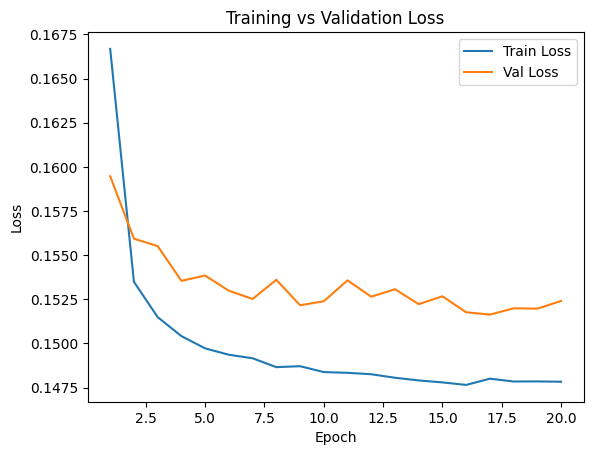

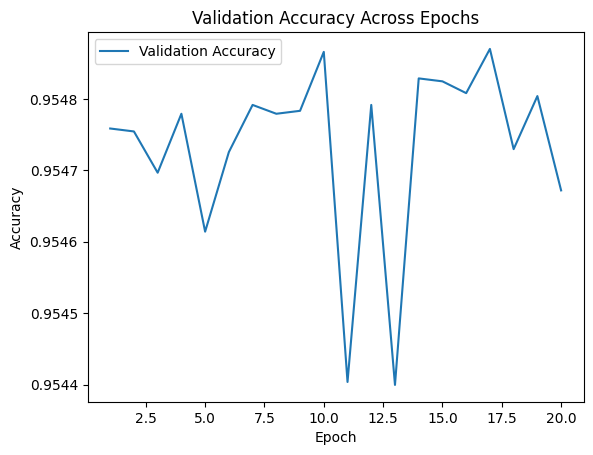

✅ Training curves plotted and saved.
Loss plot saved at: /content/outputs/plots/loss_curve.png
Accuracy plot saved at: /content/outputs/plots/val_accuracy_curve.png


In [20]:
import matplotlib.pyplot as plt

# Load logs
csv_file = f"{METRICS_DIR}/training_log_frozen.csv"
df = pd.read_csv(csv_file)

# ----- Plot Loss -----
plt.figure()
plt.plot(df['epoch'], df['train_loss'], label="Train Loss")
plt.plot(df['epoch'], df['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

loss_plot_path = f"{PLOTS_DIR}/loss_curve.png"
plt.savefig(loss_plot_path)
plt.show()

# ----- Plot Accuracy -----
plt.figure()
plt.plot(df['epoch'], df['val_accuracy'], label="Validation Accuracy")
# (train accuracy wasn't computed — only val accuracy available)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Across Epochs")
plt.legend()

acc_plot_path = f"{PLOTS_DIR}/val_accuracy_curve.png"
plt.savefig(acc_plot_path)
plt.show()

print("✅ Training curves plotted and saved.")
print(f"Loss plot saved at: {loss_plot_path}")
print(f"Accuracy plot saved at: {acc_plot_path}")

## Step 7 — Load Best Model & Evaluate on Test Set

Now that frozen-backbone training is complete:

We will:

- Load the **best checkpoint from frozen-backbone training**
- Run inference on the **test set**
- Compute evaluation metrics:
  - ✅ Test Loss
  - ✅ Test Accuracy (multi-label)
  - ✅ Per-class ROC-AUC
  - ✅ Macro ROC-AUC
- **Save predictions to CSV** (`test_predictions.csv`)
- **Save final evaluation metrics** to a summary file  
  (`final_results_frozen.csv`)

📌 **Threshold = 0.5** to convert sigmoid outputs → binary labels



In [27]:
# Load best model checkpoint
best_model_path_finetune = f"{CHECKPOINT_DIR}/densenet_frozen_best.pt"
model.load_state_dict(torch.load(best_model_path_finetune, map_location=device))
model.eval()
print("✅ Loaded best model.")

✅ Loaded best model.


In [22]:
from sklearn.metrics import roc_auc_score

test_loss = 0
correct = 0
total = 0
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        correct += (preds == labels.bool()).sum().item()
        total += labels.numel()

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

test_loss /= len(test_loader)
test_accuracy = correct / total

all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]

✅ Test Loss: 0.2326
✅ Test Accuracy: 0.9233


In [23]:
# Compute per-class AUC
class_aucs = []
for i in range(all_labels.shape[1]):
    try:
        auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
    except ValueError:
        auc = float("nan")  # class might have no positives
    class_aucs.append(auc)

macro_auc = np.nanmean(class_aucs)

print("\n📊 Per-class ROC-AUC:")
for idx, auc in enumerate(class_aucs):
    print(f"Class {idx}: {auc:.4f}")

print(f"\n🏅 Macro ROC-AUC: {macro_auc:.4f}")


📊 Per-class ROC-AUC:
Class 0: 0.6543
Class 1: 0.7097
Class 2: 0.7123
Class 3: 0.6508
Class 4: 0.6511
Class 5: 0.6590
Class 6: 0.6175
Class 7: 0.7284
Class 8: 0.6746
Class 9: 0.7787
Class 10: 0.7266
Class 11: 0.7478
Class 12: 0.6769
Class 13: 0.8244

🏅 Macro ROC-AUC: 0.7009


In [24]:
test_pred_csv = f"{METRICS_DIR}/test_predictions.csv"

df = pd.DataFrame({
    **{f"true_{i}": all_labels[:, i] for i in range(all_labels.shape[1])},
    **{f"prob_{i}": all_probs[:, i] for i in range(all_probs.shape[1])}
})

df.to_csv(test_pred_csv, index=False)
print(f"📁 Saved test predictions to {test_pred_csv}")

📁 Saved test predictions to /content/outputs/metrics/test_predictions.csv


In [25]:
# Save final metrics to CSV
results_csv = f"{METRICS_DIR}/final_results.csv"

file_exists = os.path.exists(results_csv)

with open(results_csv, "a") as f:
    if not file_exists:
        f.write("test_loss,test_accuracy,macro_auc," +
                ",".join([f"class_{i}_auc" for i in range(len(class_aucs))]) + "\n")

    f.write(f"{test_loss:.4f},{test_accuracy:.4f},{macro_auc:.4f}," +
            ",".join([f"{auc:.4f}" for auc in class_aucs]) + "\n")

print(f"✅ Saved final test metrics to {results_csv}")

✅ Saved final test metrics to /content/outputs/metrics/final_results.csv


## 📦 Save Frozen-Backbone Outputs to Google Drive

We now copy all results from `outputs/` to Google Drive under:

**Google Drive path:**
`MyDrive/FML_Project/densenet/frozen_backbone/`

This preserves model checkpoints, logs, evaluation results, and training plots for future use and keeps results organized by model and training stage.


In [26]:
drive_base = "/content/drive/MyDrive/FML_Project/densenet/frozen_backbone"
subdirs = ["checkpoints", "metrics", "plots"]

# Create target folders if not exist
for sub in subdirs:
    os.makedirs(f"{drive_base}/{sub}", exist_ok=True)

# Copy data
shutil.copytree("outputs/checkpoints", f"{drive_base}/checkpoints", dirs_exist_ok=True)
shutil.copytree("outputs/metrics", f"{drive_base}/metrics", dirs_exist_ok=True)
shutil.copytree("outputs/plots", f"{drive_base}/plots", dirs_exist_ok=True)

print("✅ Frozen-backbone outputs copied to Drive.")

✅ Frozen-backbone outputs copied to Drive.
